In [62]:
import torch
import numpy as np
import pandas as pd
import os 

In [63]:
from load_model import load_model, DEVICE
from modules import AverageWrapper
from eval_model import get_model_structure
from region_identification_utils import get_lineage_cells


path_model1 = '/data/nchand/analysis/BPcm/BP68_L0_0/complete/06-12-2024.16.34/best_model'
path_model2 = '/data/nchand/analysis/BPcm/BP68_L-1_5/complete/06-10-2024.00.46/best_model'
lineage_filepath = 'immgen_lineages.csv' # insert path to file here
cell_names = np.load("/data/nchand/ImmGen/mouse/BPprofiles1000/ImmGenATAC1219.peak_matched_in_sorted.sl10004sh-4.celltypes.npy")


model1 = load_model(path_model1, model_structure=get_model_structure('BPcm', 300, 90), n_filters=300, verbose=False)
model2 = load_model(path_model2, model_structure=get_model_structure('BPcm', 300, 90), n_filters=300, verbose=False)

lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)

lineage_model1 = AverageWrapper(model1, lineage_cell_indices)
lineage_model2 = AverageWrapper(model2, lineage_cell_indices)


lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)

lineage_model1 = AverageWrapper(model1, lineage_cell_indices)
lineage_model2 = AverageWrapper(model2, lineage_cell_indices)

Selected GPU: 3
DEVICE is cuda:3
199
39
7
DEVICE is cuda:3
998 300 90
199
39
7
DEVICE is cuda:3
998 300 90


In [64]:
def get_pred(model, region_onehot, region_bias):
    X = torch.from_numpy(np.expand_dims(region_onehot, axis=0)).to(DEVICE)
    bias = torch.from_numpy(region_bias).to(DEVICE)

    print('region_onehot shape:', region_onehot.shape)
    print('region_bias shape before expand:', region_bias.shape)
    print('X shape after expand:', X.shape)
    print('bias shape after to_device:', bias.shape)

    model.eval()
    print('X shape', X.size())
    print('bias shape in get pred', bias.size())
    with torch.no_grad():
        profile, scalar = model(X, bias)
    return torch.squeeze(profile).cpu().numpy(), np.squeeze(torch.squeeze(scalar).cpu().numpy())

def get_scalar_preds(model, n_examples, onehot_seq, bias):

    predicted_scalars = np.zeros((n_examples, len(lineage_names)))
    for i in range(n_examples):
        region_onehot = onehot_seq[i]
        region_bias = bias[i]
        pred_prof, pred_scalar = get_pred(model, region_onehot, region_bias)
        predicted_scalars[i] = pred_scalar
    return predicted_scalars

In [86]:

REL = "GGGAATTTCCC"
PTF1A = "TTCACACCTG"
MOTIF_53 = "GCAGCGGTATAGTACAGCCC"

bases = ['A', 'C', 'G', 'T'] # from /data/nchand/mm10/mm10ImmGenATAC1219.peak_matched1000bp_onehot-ACGT_alignleft.npz

motif = REL
motif_name = "REL"
n_sequences=30000


n_examples = 1000

bias_dir = '/data/mostafavilab/ImgenATAC/Tn5biasBuenrostro2022/Biaspredictions'
file_name = f'lp5_30000_marginalization_{motif_name}after_insertion_seqfromselectedBACs_gt6avgcount_N500000bp1200_countsonhg38selectedBACs_onehot_ACGT_alignleft-cv10-0-n1outb_lfJSDnk200l25TkfGELUbp1re_dc5i1d2-4-8-16-32s1l5r11-1FSoftmaxtr0.001Adambs256-F_embedding-1.npz'


marg_0 = np.load(f'/data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3/l0_{n_sequences}_marginalization_{motif_name}.npz')
y_before_0, y_after_0 = marg_0['y_before'], marg_0['y_after']
marg_p5 = np.load(f'/data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3/lp5_{n_sequences}_marginalization_{motif_name}.npz')
y_before_p5, y_after_p5 = marg_p5['y_before'], marg_p5['y_after'] 
before_insertion_seq, after_insertion_seq = marg_0['before_insertion_seq'], marg_0['after_insertion_seq']


f = np.load(os.path.join(bias_dir, file_name))
# bias_counts[:, :, 2:] # keep all peaks, and only the last 998 bp
bias_marg = f['counts']
print('bias marg before correction shape', bias_marg.shape)
# adjust bias for the off-by-two error
bias_marg = bias_marg[:, :, 2:]
print('marg bias shape', bias_marg.shape)

print("bias_marg shape:", bias_marg.shape)
print("after_insertion_seq shape:", after_insertion_seq.shape)

scalar_preds_0_with_motif = get_scalar_preds(lineage_model1, n_examples, onehot_seq = after_insertion_seq, bias=bias_marg)
scalar_preds_p5_with_motif = get_scalar_preds(lineage_model2, n_examples, onehot_seq=after_insertion_seq, bias=bias_marg)

scalar_preds_0_no_motif = get_scalar_preds(lineage_model1, n_examples, onehot_seq = before_insertion_seq, bias=bias_marg)
scalar_preds_p5_no_motif = get_scalar_preds(lineage_model2, n_examples, onehot_seq=before_insertion_seq, bias=bias_marg)


diff_0 = np.log(scalar_preds_0_with_motif) - np.log(scalar_preds_0_no_motif)
diff_p5 = np.log(scalar_preds_p5_with_motif) - np.log(scalar_preds_p5_no_motif)


bias marg before correction shape (30000, 1, 1000)
marg bias shape (30000, 1, 998)
bias_marg shape: (30000, 1, 998)
after_insertion_seq shape: (30000, 4, 998)
region_onehot shape: (4, 998)
region_bias shape before expand: (1, 998)
X shape after expand: torch.Size([1, 4, 998])
bias shape after to_device: torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
region_onehot shape: (4, 998)
region_bias shape before expand: (1, 998)
X shape after expand: torch.Size([1, 4, 998])
bias shape after to_device: torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
region_onehot shape: (4, 998)
region_bias shape before expand: (1, 998)
X shape after expand: torch.Size([1, 4, 998])
bias shape after to_device: torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
region_onehot shape: (4, 998)
region_bias shape before expand: (1, 998)
X shape after expand: torch.Size([1, 4, 

[ 18.83601208  68.68185355  67.60578746  78.32609908  59.25842663
  85.65421077 113.94436054 122.23681881  90.843539    65.34777507]
[ 18.23398121  73.1687642   71.60058445  83.26387239  60.85284801
  80.32875071 113.53705199 119.36520494  95.93020149  68.06860804]


<Figure size 640x480 with 0 Axes>

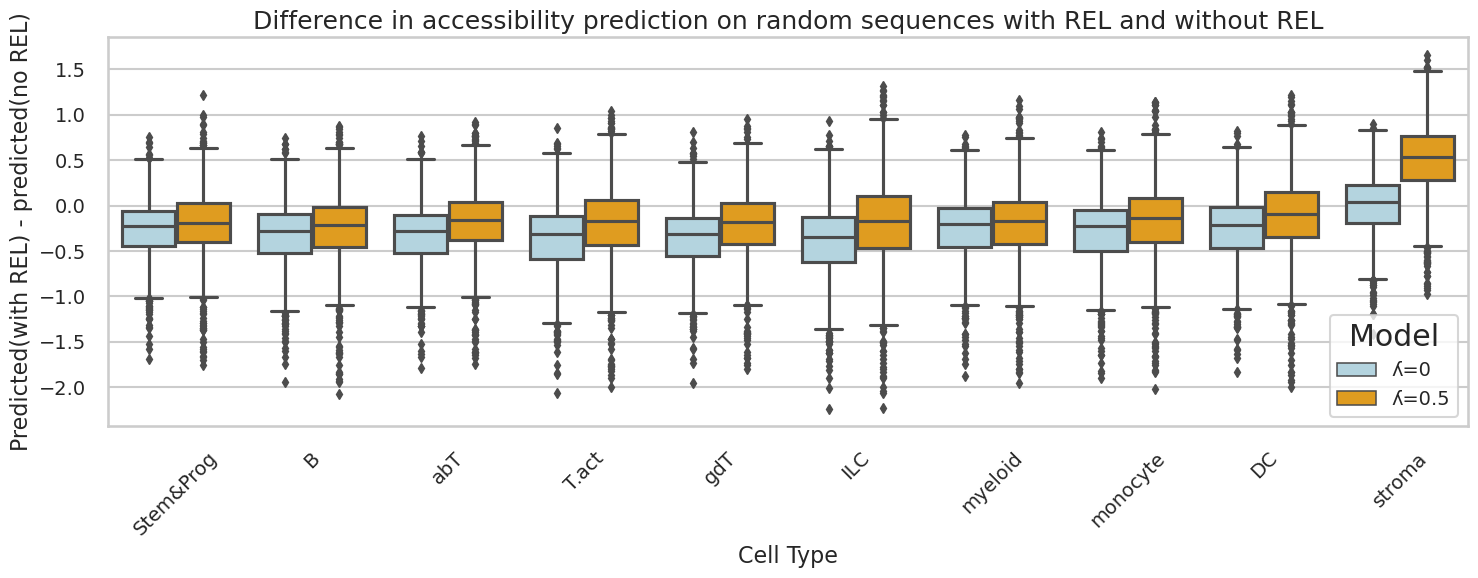

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Prepare the data for plotting
def create_comparison_boxplot(preds_model1, preds_model2, cellnames, motif_name, figsize=(15, 6)):
    # Create a dataframe in long format
    plt.clf()
    data_list = []
    
    # For each celltype
    for i in range(10):
        # Add data for model1
        data_list.extend([{
            'Celltype': f'{cellnames[i]}',
            'Model': 'ʎ=0',
            'Prediction': val
        } for val in preds_model1[:, i]])
        
        # Add data for model2
        data_list.extend([{
            'Celltype': f'{cellnames[i]}',
            'Model': 'ʎ=0.5',
            'Prediction': val
        } for val in preds_model2[:, i]])
    
    df = pd.DataFrame(data_list)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create boxplot using seaborn
    sns.boxplot(data=df, x='Celltype', y='Prediction', hue='Model', 
                palette=['lightblue', 'orange'])
    
    # Customize the plot
    plt.xticks(rotation=45)
    plt.title(f'Difference in accessibility prediction on random sequences with {motif_name} and without {motif_name}')
    plt.xlabel('Cell Type')
    plt.ylabel(f'Predicted(with {motif_name}) - predicted(no {motif_name})')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Usage:
boxplot = create_comparison_boxplot(diff_0, diff_p5, cellnames=lineage_names, motif_name=motif_name)
plt.show()

In [51]:
plt.clf()

<Figure size 640x480 with 0 Axes>